In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, precision_recall_curve, auc

# Import Dataset

In [5]:
df = pd.read_csv('../00_dataset/YelpZip/metadata', 
                 sep='\t',
                 header=None,
                 names=["user_id", "prod_id", "rating", "label", "date"])
df

,user_id,prod_id,rating,label,date
0,5044,0,1.0,-1,2014-11-16
1,5045,0,1.0,-1,2014-09-08
2,5046,0,3.0,-1,2013-10-06
3,5047,0,5.0,-1,2014-11-30
4,5048,0,5.0,-1,2014-08-28
...,...,...,...,...,...
608593,119664,5039,4.0,1,2013-01-20
608594,56277,5039,2.0,1,2012-11-12
608595,265320,5039,1.0,1,2012-08-22
608596,161722,5039,4.0,1,2011-05-11


# Dataset Pre-processing
Minimal cleanup because feature engineering will be using and converting date values.

In [6]:
# Check for Null values
df.isnull().sum()

user_id    0
prod_id    0
rating     0
label      0
date       0
dtype: int64

In [7]:
df['label'] = df['label'].replace(-1, 0)
y = df['label']
X = df.drop('label', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [8]:
print(f"""
X_train: {X_train.shape}
X_test: {X_test.shape}
y_train: {y_train.shape}
y_test: {y_test.shape}
""")


X_train: (426018, 4)
X_test: (182580, 4)
y_train: (426018,)
y_test: (182580,)



# Define Models

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier  # Boosting
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

models = {
    "LR": LogisticRegression(),
    "NN": MLPClassifier(),
    "KNN": KNeighborsClassifier(),
    "DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(),
    "AB": AdaBoostClassifier(),
    "XGB": XGBClassifier(),
    "NB": GaussianNB(),
}

# Example usage: print model names
for category, model in models.items():
    print(f"{category}: {model.__class__.__name__}")

LR: LogisticRegression
NN: MLPClassifier
KNN: KNeighborsClassifier
DT: DecisionTreeClassifier
RF: RandomForestClassifier
AB: AdaBoostClassifier
XGB: XGBClassifier
NB: GaussianNB


# Create pipeline

In [10]:
# X_train['date'] = pd.to_datetime(X_train['date']).astype('int64') // 10**9
# X_test['date'] = pd.to_datetime(X_test['date']).astype('int64') // 10**9
# X_train = X_train.drop(columns=["user_id", "prod_id"])
# X_test = X_test.drop(columns=["user_id", "prod_id"])

results = []


In [11]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from FeatureEngineer import CombinedEngineer
from SmoteTransformer import SMOTETransformer

# Dictionary mapping feature selection methods to columns to drop
drop_columns_dict = {
    "baseline": set(),
    "MI": {'user_earliest', 'extreme_rating_index', 'total_reviews_for_restaurant', 'avg_rating_for_restaurant', 
           'review_frequency_for_restaurant', 'user_latest', 'std_dev_rating_for_restaurant', 'rating_min', 'date'},
    "Lasso_MI": {'user_earliest', 'extreme_rating_index', 'total_reviews_for_restaurant', 'avg_rating_for_restaurant', 
                 'review_frequency_for_restaurant', 'user_latest', 'std_dev_rating_for_restaurant', 'rating_min', 'date', 
                 'user_restaurants_reviewed'},
    "RFE": {'rating_max', 'median_rating_for_restaurant', 'extreme_rating_index', 'rating', 'user_restaurants_reviewed', 
            'rating_std', 'user_active_percentage', 'user_days_active', 'rating_min'},
    "Lasso_RFE": {'rating_max', 'median_rating_for_restaurant', 'extreme_rating_index', 'rating', 'user_restaurants_reviewed', 
                  'rating_std', 'user_active_percentage', 'user_days_active', 'rating_min', 'user_earliest'},
    "RFECV": {'rating_max', 'median_rating_for_restaurant', 'rating'},
    "Lasso_RFECV": {'rating_max', 'median_rating_for_restaurant', 'rating', 'user_earliest', 'user_restaurants_reviewed'}
}

# Iterate over each feature selection method
for feature_selection_method, drop_columns in drop_columns_dict.items():
    results = []  # Store results for this feature selection method

    print(f"\n=== Feature Selection: {feature_selection_method} ===")

    for model_name, model in models.items():
        print(f"Evaluating {model_name} with {feature_selection_method}...")

        # Define pipeline
        pipeline = Pipeline([
            ('feature_engineering', CombinedEngineer(drop_columns = list(drop_columns_dict.get(feature_selection_method, set()))
)),  # Drop selected columns
            ('scaler', StandardScaler()),  # Scaling
            ('smote', SMOTE(sampling_strategy='auto', random_state=42)),  # SMOTE
            ('classifier', model)  # Model
        ])

        # Train model
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')
        balanced_acc = balanced_accuracy_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)

        # Probability predictions
        y_pred_proba = pipeline.predict_proba(X_test)

        # ROC-AUC
        roc_auc_0 = roc_auc_score(y_test, y_pred_proba[:, 0])
        roc_auc_1 = roc_auc_score(y_test, y_pred_proba[:, 1])

        # PR-AUC
        precision_0, recall_0, _ = precision_recall_curve(y_test, y_pred_proba[:, 0])
        pr_auc_0 = auc(recall_0, precision_0)

        precision_1, recall_1, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
        pr_auc_1 = auc(recall_1, precision_1)

        # Append results
        results.append({
            "Model": model_name,
            "Feature Selection": feature_selection_method,
            "Accuracy": f"{accuracy:.4f}",
            "Precision": f"{precision:.4f}",
            "Recall": f"{recall:.4f}",
            "F1 Score": f"{f1:.4f}",
            "Balanced Accuracy": f"{balanced_acc:.4f}",
            "MCC": f"{mcc:.4f}",
            "PR-AUC_0": f"{pr_auc_0:.4f}",
            "PR-AUC_1": f"{pr_auc_1:.4f}",
            "ROC-AUC_0": f"{roc_auc_0:.4f}",
            "ROC-AUC_1": f"{roc_auc_1:.4f}"
        })

    # Save results for this feature selection method
    results_df = pd.DataFrame(results)
    filename = f"b3_results_{feature_selection_method}_v2.csv"
    results_df.to_csv(filename, index=False)

    print(f"Results saved to {filename}\n")

print("All models trained and results saved.")



=== Feature Selection: baseline ===
Evaluating LR with baseline...
Evaluating NN with baseline...


c:\Users\Admin\Documents\GitHub\INF2008_YelpZip\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluating KNN with baseline...
Evaluating DT with baseline...
Evaluating RF with baseline...
Evaluating AB with baseline...
Evaluating XGB with baseline...
Evaluating NB with baseline...
Results saved to b3_results_baseline_v2.csv


=== Feature Selection: MI ===
Evaluating LR with MI...
Evaluating NN with MI...
Evaluating KNN with MI...
Evaluating DT with MI...
Evaluating RF with MI...
Evaluating AB with MI...
Evaluating XGB with MI...
Evaluating NB with MI...
Results saved to b3_results_MI_v2.csv


=== Feature Selection: Lasso_MI ===
Evaluating LR with Lasso_MI...
Evaluating NN with Lasso_MI...
Evaluating KNN with Lasso_MI...
Evaluating DT with Lasso_MI...
Evaluating RF with Lasso_MI...
Evaluating AB with Lasso_MI...
Evaluating XGB with Lasso_MI...
Evaluating NB with Lasso_MI...
Results saved to b3_results_Lasso_MI_v2.csv


=== Feature Selection: RFE ===
Evaluating LR with RFE...
Evaluating NN with RFE...
Evaluating KNN with RFE...
Evaluating DT with RFE...
Evaluating RF with RFE...


In [14]:
# results_df

In [15]:
# 1. Access individual steps in the pipeline
feature_engineering_step = pipeline.named_steps['feature_engineering']
scaler_step = pipeline.named_steps['scaler']
smote_step = pipeline.named_steps['smote']
classifier_step = pipeline.named_steps['classifier']

X_engineered = X_train
# 2. Check the transformed data at each step
# For training data
X_engineered = feature_engineering_step.transform(X_train)
X_scaled = scaler_step.transform(X_engineered)
X_resampled, y_resampled = smote_step.fit_resample(X_scaled, y_train)

# 3. Check shapes to understand SMOTE's effect
print(f"Original X_train shape: {X_train.shape}")
print(f"After engineering: {X_engineered.shape}")
print(f"After scaling: {X_scaled.shape}")
print(f"After SMOTE: {X_resampled.shape}, y_resampled: {y_resampled.shape}")

# 4. Compare class distributions
from collections import Counter
print(f"Original class distribution: {Counter(y_train)}")
print(f"Resampled class distribution: {Counter(y_resampled)}")

# 5. Extract feature importances (if classifier supports it)
if hasattr(classifier_step, 'feature_importances_'):
    importances = classifier_step.feature_importances_
    print(importances)

    # Print top features
elif hasattr(classifier_step, 'coef_'):
    importances = classifier_step.coef_[0]

Original X_train shape: (426018, 4)
After engineering: (426018, 14)
After scaling: (426018, 14)
After SMOTE: (739384, 14), y_resampled: (739384,)
Original class distribution: Counter({1: 369692, 0: 56326})
Resampled class distribution: Counter({0: 369692, 1: 369692})


In [16]:
# checking versions (sync with kaggle if using)
import sys
import numpy as np
import pandas as pd
import sklearn

print("Python Version:", sys.version)
print("NumPy Version:", np.__version__)
print("Pandas Version:", pd.__version__)
print("Scikit-Learn Version:", sklearn.__version__)

Python Version: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
NumPy Version: 2.2.3
Pandas Version: 2.2.3
Scikit-Learn Version: 1.6.1


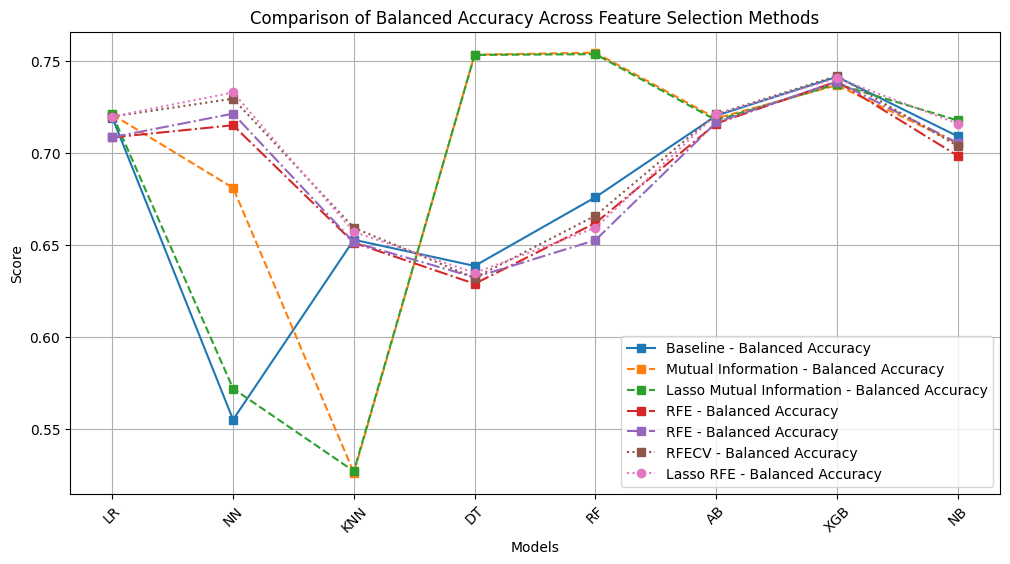

In [42]:
# Load the datasets
baseline_info_df = pd.read_csv("results/b3_results_baseline_v2.csv")
mutual_info_df = pd.read_csv("results/b3_results_MI_v2.csv")
lasso_mutual_info_df = pd.read_csv("results/b3_results_Lasso_MI_v2.csv")
rfe_df = pd.read_csv("results/b3_results_RFE_v2.csv")
lasso_rfe_df = pd.read_csv("results/b3_results_Lasso_RFE_v2.csv")
rfecv_df = pd.read_csv("results/b3_results_RFECV_v2.csv")
lasso_rfecv_df = pd.read_csv("results/b3_results_Lasso_RFECV_v2.csv")


# Rename columns for better readability
baseline_info_df.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
mutual_info_df.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
lasso_mutual_info_df.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
rfe_df.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
lasso_rfe_df.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
rfecv_df.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
lasso_rfecv_df.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)

# Extract models and metrics
models = mutual_info_df["Model"]

balanced_accuracy_baseline = baseline_info_df["Balanced Accuracy"]
balanced_accuracy_mutual_info = mutual_info_df["Balanced Accuracy"]
balanced_accuracy_lasso_mutual_info_df = lasso_mutual_info_df["Balanced Accuracy"]
balanced_accuracy_rfe = rfe_df["Balanced Accuracy"]
balanced_accuracy_lasso_rfe = lasso_rfe_df["Balanced Accuracy"]
balanced_accuracy_rfecv = rfecv_df["Balanced Accuracy"]
balanced_accuracy_lasso_rfecv = lasso_rfecv_df["Balanced Accuracy"]

# Overlay both Accuracy and Balanced Accuracy in a single plot
plt.figure(figsize=(12, 6))

# Balanced Accuracy lines
plt.plot(models, balanced_accuracy_baseline, marker="s", label="Baseline - Balanced Accuracy", linestyle="-")
plt.plot(models, balanced_accuracy_mutual_info, marker="s", label="Mutual Information - Balanced Accuracy", linestyle="--")
plt.plot(models, balanced_accuracy_lasso_mutual_info_df, marker="s", label="Lasso Mutual Information - Balanced Accuracy", linestyle="--")
plt.plot(models, balanced_accuracy_rfe, marker="s", label="RFE - Balanced Accuracy", linestyle="-.")
plt.plot(models, balanced_accuracy_lasso_rfe, marker="s", label="RFE - Balanced Accuracy", linestyle="-.")
plt.plot(models, balanced_accuracy_rfecv, marker="s", label="RFECV - Balanced Accuracy", linestyle=":")
plt.plot(models, balanced_accuracy_lasso_rfecv , marker="o", label="Lasso RFE - Balanced Accuracy", linestyle=":")

plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Comparison of Balanced Accuracy Across Feature Selection Methods")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


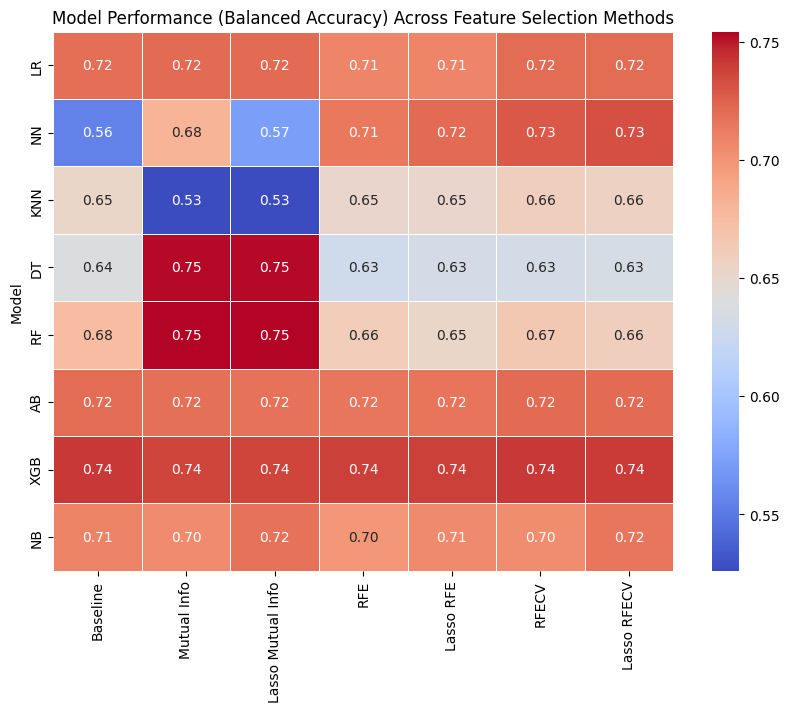

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load CSVs
baseline_info_df = pd.read_csv("results/b3_results_baseline_v2.csv")
mutual_info_df = pd.read_csv("results/b3_results_MI_v2.csv")
lasso_mutual_info_df = pd.read_csv("results/b3_results_Lasso_MI_v2.csv")
rfe_df = pd.read_csv("results/b3_results_RFE_v2.csv")
lasso_rfe_df = pd.read_csv("results/b3_results_Lasso_RFE_v2.csv")
rfecv_df = pd.read_csv("results/b3_results_RFECV_v2.csv")
lasso_rfecv_df = pd.read_csv("results/b3_results_Lasso_RFECV_v2.csv")


# Ensure the first column is "Model" and set it as index
baseline_info_df.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
mutual_info_df.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
lasso_mutual_info_df.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
rfe_df.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
lasso_rfe_df.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
rfecv_df.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
lasso_rfecv_df.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)


# Set the index to "Model" column
baseline_info_df.set_index("Model", inplace=True)
mutual_info_df.set_index("Model", inplace=True)
lasso_mutual_info_df.set_index("Model", inplace=True)
rfe_df.set_index("Model", inplace=True)
lasso_rfe_df.set_index("Model", inplace=True)
rfecv_df.set_index("Model", inplace=True)
lasso_rfecv_df.set_index("Model", inplace=True)


# Select only the "Balanced Accuracy" column from each DataFrame and rename it for clarity
baseline_acc = baseline_info_df[['Balanced Accuracy']].rename(columns={"Balanced Accuracy": "Baseline"})
mutual_info_acc = mutual_info_df[['Balanced Accuracy']].rename(columns={"Balanced Accuracy": "Mutual Info"})
lasso_mutual_info_acc = lasso_mutual_info_df[['Balanced Accuracy']].rename(columns={"Balanced Accuracy": "Lasso Mutual Info"})
rfe_acc = rfe_df[['Balanced Accuracy']].rename(columns={"Balanced Accuracy": "RFE"})
lasso_rfe_acc = lasso_rfe_df[['Balanced Accuracy']].rename(columns={"Balanced Accuracy": "Lasso RFE"})
rfecv_acc = rfecv_df[['Balanced Accuracy']].rename(columns={"Balanced Accuracy": "RFECV"})
lasso_rfecv_acc = lasso_rfecv_df[['Balanced Accuracy']].rename(columns={"Balanced Accuracy": "Lasso RFECV"})

# Merge all dataframes on "Model" index
merged_df = baseline_acc.join([mutual_info_acc, lasso_mutual_info_acc, rfe_acc, lasso_rfe_acc, rfecv_acc, lasso_rfecv_acc], how="inner")

# Convert values to float (important for heatmap)
merged_df = merged_df.astype(float)

# Create Heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(merged_df, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")

# Title and Display
plt.title("Model Performance (Balanced Accuracy) Across Feature Selection Methods")
plt.show()


<Figure size 1200x600 with 0 Axes>

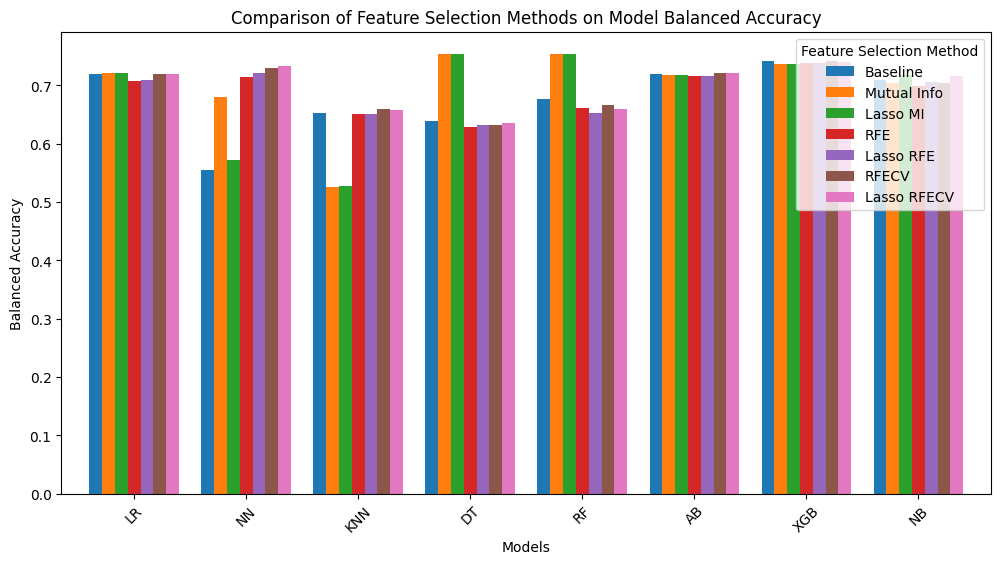

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Manually load CSV files
baseline_info_df = pd.read_csv("results/b3_results_baseline_v2.csv")
mutual_info_df = pd.read_csv("results/b3_results_MI_v2.csv")
lasso_mutual_info_df = pd.read_csv("results/b3_results_Lasso_MI_v2.csv")
rfe_df = pd.read_csv("results/b3_results_RFE_v2.csv")
lasso_rfe_df = pd.read_csv("results/b3_results_Lasso_RFE_v2.csv")
rfecv_df = pd.read_csv("results/b3_results_RFECV_v2.csv")
lasso_rfecv_df = pd.read_csv("results/b3_results_Lasso_RFECV_v2.csv")

# Ensure the first column is "Model" and set it as index
dfs = [baseline_info_df, mutual_info_df, lasso_mutual_info_df, rfe_df, 
       lasso_rfe_df, rfecv_df, lasso_rfecv_df]
df_names = ["Baseline", "Mutual Info", "Lasso MI", "RFE", 
            "Lasso RFE", "RFECV", "Lasso RFECV"]

for df in dfs:
    df.rename(columns={'Unnamed: 0': 'Model'}, inplace=True)
    df.set_index("Model", inplace=True)

# Select "Balanced Accuracy" from each DataFrame and rename it
balanced_acc_dfs = [
    baseline_info_df[['Balanced Accuracy']].rename(columns={"Balanced Accuracy": "Baseline"}),
    mutual_info_df[['Balanced Accuracy']].rename(columns={"Balanced Accuracy": "Mutual Info"}),
    lasso_mutual_info_df[['Balanced Accuracy']].rename(columns={"Balanced Accuracy": "Lasso MI"}),
    rfe_df[['Balanced Accuracy']].rename(columns={"Balanced Accuracy": "RFE"}),
    lasso_rfe_df[['Balanced Accuracy']].rename(columns={"Balanced Accuracy": "Lasso RFE"}),
    rfecv_df[['Balanced Accuracy']].rename(columns={"Balanced Accuracy": "RFECV"}),
    lasso_rfecv_df[['Balanced Accuracy']].rename(columns={"Balanced Accuracy": "Lasso RFECV"})
]

# Merge all DataFrames
merged_df = balanced_acc_dfs[0]
for df in balanced_acc_dfs[1:]:
    merged_df = merged_df.join(df, how="inner")

# Plot grouped bar chart
plt.figure(figsize=(12, 6))
merged_df.plot(kind="bar", figsize=(12, 6), width=0.8)

# Labels and title
plt.ylabel("Balanced Accuracy")
plt.xlabel("Models")
plt.title("Comparison of Feature Selection Methods on Model Balanced Accuracy")
plt.legend(title="Feature Selection Method")
plt.xticks(rotation=45)

# Show plot
plt.show()


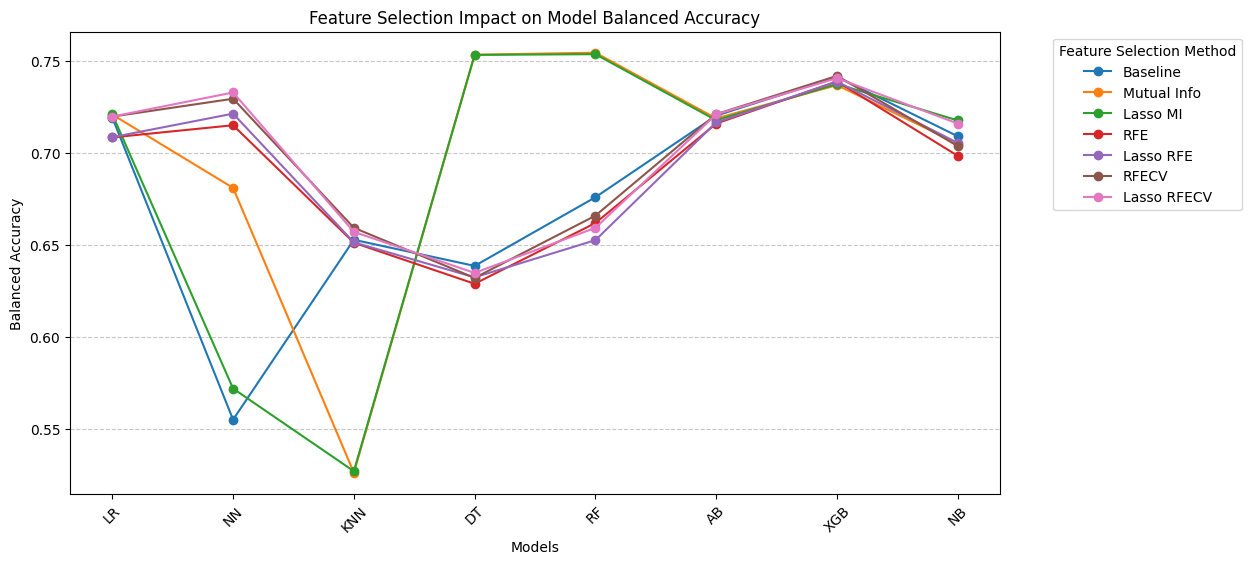

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot each feature selection method with a distinct marker
for column in merged_df.columns:
    plt.plot(merged_df.index, merged_df[column], marker='o', label=column)

# Labels and title
plt.ylabel("Balanced Accuracy")
plt.xlabel("Models")
plt.title("Feature Selection Impact on Model Balanced Accuracy")
plt.legend(title="Feature Selection Method", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


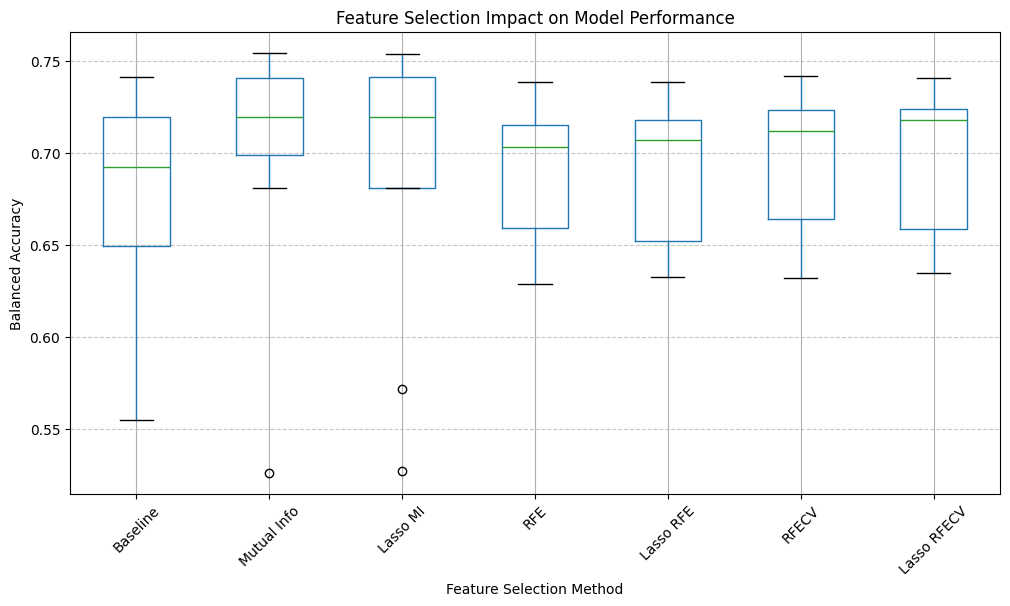

In [3]:
plt.figure(figsize=(12, 6))
merged_df.boxplot()

plt.ylabel("Balanced Accuracy")
plt.xlabel("Feature Selection Method")
plt.title("Feature Selection Impact on Model Performance")

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
